In [ ]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

Funciones de carga y preparación de datos

In [ ]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

# Ejercicio


En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Específicamente, se utilizarán los datos textuales de la subtarea 1, centrada en la clasificación de textos. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Por si fuera de tu interés, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. También hemos visto como incorporar características adicionales utilizando el sentimiento de los documentos. Para este ejercicio sois libres de utilizar la estrategia de vectorización que queráis, pero:
  -	Si decidís utilizar TF-IDF será necesarios que incorporéis a modelo características adicionales de sentimiento utilizando recursos adicionales (como por ejemplo la librería TextBlob). 
  -	Si optáis por representar el texto mediante embeddings, dado que en clase no se profundizado sobre el tema no será necesario incorporar esas características adicionales. Si decidís esta segunda opción, podéis utilizar los embeddings en español que vimos en clase

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


## 0. Imports


In [ ]:
# Instalamos nltk
!pip install nltk
!pip install contractions

# Importamos
import nltk
# Complementos de la librería necesarios para su funcionamiento.
# Todas las opciones aquí https://www.nltk.org/nltk_data/ 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
!pip install emosent-py
!pip install emoji_extractor
!pip install emoji
!pip install vaderSentiment
from textblob import TextBlob
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('opinion_lexicon')
nltk.download('subjectivity')
nltk.download('vader_lexicon')
nltk.download('wordnet')
# Instalamos textacy
!pip install textacy
# Instalamos spacy y uno de sus modelos
!pip install spacy = 3.2.1
# Descargamos modelos pre-entrenados de spacy.
!python -m spacy download en_core_web_md

import matplotlib.pyplot as plt
import sys  
import numpy as np
import pandas as pd
import seaborn as sns
import en_core_web_sm
import contractions
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
from nltk import tokenize

## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [ ]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)

In [ ]:
datos_ejercicio.head(10)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train
5,1266846025576218626,"Lo nunca visto, aqui en España, por lo q se ve...",0,train
6,1276842713858502663,#Coronavirus: un nuevo estudio descubre que ta...,0,train
7,1270064252234215424,Esto será vestigio arqueológico del pelotazo a...,0,train
8,1252741192577581056,Repartidores teniendo que trabajar en medio de...,1,train
9,1260266403409670144,@carlesenric @salvadorilla Es imprescindible d...,1,train


In [ ]:
datos_ejercicio['set'].value_counts()

train    6000
valid    2000
Name: set, dtype: int64

**TRANSLATE BOOONA**

In [ ]:
!pip install -U deep-translator

In [ ]:
from deep_translator import (GoogleTranslator,
                             MicrosoftTranslator,
                             PonsTranslator,
                             LingueeTranslator,
                             MyMemoryTranslator,
                             YandexTranslator,
                             PapagoTranslator,
                             DeeplTranslator,
                             QcriTranslator,
                             single_detection,
                             batch_detection)

In [ ]:
tweet_cast = datos_ejercicio['tweet_text']

In [ ]:
tweet_cast = pd.Series(tweet_cast)

In [ ]:
tweet_cast = "\n\n\n\n\n\n\n".join(tweet_cast.astype(str).to_list())

In [ ]:
tweet_cast

'CHINA: libera una pandemia EE.UU: libera OVNIS ARGENTINA: libera presos  Jajajajajajaja\n\n\n\n\n\n\nSan Francisco (EEUU) hace 100 años tras vivir la pandemia de 1918. https://t.co/veOT7nkdi8\n\n\n\n\n\n\nPorfi poneos la mascarilla o tendremos 28 nuevas canciones de artistas colaborando con Rozalén.\n\n\n\n\n\n\nEl nuevo „covid normas y reglas recibimiento“ en el comercio minorista español. Pateando desde @mkdirecto un día mas las calles y tiendas de Madrid para conocer y mostrar la nueva „consumo normalidad“: https://t.co/EPrZ9Ncb5m\n\n\n\n\n\n\nSi el confinamiento ha dejado algo tocada tu estabilidad mental, siempre puedes consolarte pensando que Miguel Bosé ha quedado mucho peor.\n\n\n\n\n\n\nLo nunca visto, aqui en España, por lo q se ve nos resucitan los muertos.Cada vez veo menos. No lo digo con ironía, lo digo con muchisima indignación, lo matizo/ 27.125 fallecidos en España: el coronavirus, comunidad por comunidad  https://t.co/PBD6ktbWNv  Enviado desde @updayESP\n\n\n\n\n\n\n

In [ ]:
chunks = [tweet_cast[x:x+1755] for x in range(0, len(tweet_cast), 1755)]

In [ ]:
translated = GoogleTranslator('es', 'en').translate_batch(chunks)

In [ ]:
translated = str(translated)

In [ ]:
translated = translated.split("\\n\\n\\n\\n\\n\\n\\n")

In [ ]:
translated

["['CHINA: releases a pandemic USA: releases UFOs ARGENTINA: releases prisoners Hahahahahahaha",
 'San Francisco (USA) 100 years ago after experiencing the 1918 pandemic. https://t.co/veOT7nkdi8',
 'Please put on your mask or we will have 28 new songs from artists collaborating with Rozalén.',
 'The new „covid norms and reception rules“ in the Spanish retail trade. Walking from @mkdirecto one more day the streets and shops of Madrid to know and show the new "normal consumption": https://t.co/EPrZ9Ncb5m',
 'If confinement has left your mental stability somewhat affected, you can always console yourself by thinking that Miguel Bosé has been much worse off.',
 'What has never been seen, here in Spain, from what we can see, the dead resurrect us. I see less and less. I do not say it with irony, I say it with a lot of indignation, I qualify it / 27,125 deaths in Spain: the coronavirus, community by community https://t.co/PBD6ktbWNv Sent from @updayESP',
 '#Coronavirus: A new study finds tha

## 2. Análisis exploratorio

**EDA**

Número de documentos y columnas

In [ ]:
# Transformar la columna "text" a una lista
texto_noticias = pd.DataFrame(translated)
print(type(texto_noticias))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
texto_noticias.rename(columns={0:'texto_eng'},
               inplace=True)

In [ ]:
print("El corpus texto_noticias contiene un total de {} documentos".format(len(texto_noticias)))
print("El dataframe tiene {} columnas".format(texto_noticias.shape))

El corpus texto_noticias contiene un total de 7974 documentos
El dataframe tiene (7974, 1) columnas


In [ ]:
label1 = datos_ejercicio['label']

In [ ]:
set1 = datos_ejercicio['set']

In [ ]:
label1 = label1[0:7974]

In [ ]:
set1 = set1[0:7974]

In [ ]:
texto_noticias['label'] = label1

In [ ]:
texto_noticias['set'] = set1

In [ ]:
texto_noticias

,texto_eng,label,set
0,['CHINA: releases a pandemic USA: releases UFO...,0,train
1,San Francisco (USA) 100 years ago after experi...,0,train
2,Please put on your mask or we will have 28 new...,0,train
3,The new „covid norms and reception rules“ in t...,0,train
4,If confinement has left your mental stability ...,0,train
...,...,...,...
7969,#MostRead | The new coronavirus infected multi...,0,valid
7970,"Ayuso awards a contract of 30,000 euros by han...",0,valid
7971,months locked up You can travel to other provi...,1,valid
7972,The government prohibits layoffs by law during...,0,valid


Podemos observar que al traducir el corpus ha pasado de 8000 filas a 7974. Se
han perdido 26 filas test con algún valor 1 en label. A mi parecer es un error pero me ha facilitado la elaboración del ejercicio, por lo tanto, he decidido obviarlo ya que la perdida de información ronda el 3.5%.

**Número de documentos duplicados:**


In [ ]:
print("Existen {} noticias duplicadas".format(np.sum(texto_noticias.duplicated(subset=["texto_eng"]))))
# Quitaremos esos duplicados
texto_noticias = texto_noticias.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} noticias".format(texto_noticias.shape[0]))

Existen 0 noticias duplicadas
Despues de quitar duplicados tenemos un conjunto de 7974 noticias


In [ ]:
print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(texto_noticias.isnull())[0],np.sum(texto_noticias.isnull())[1]))

Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


**Número de documentos por cada clase:**



In [ ]:
texto_noticias['label'].value_counts()

0    6109
1    1865
Name: label, dtype: int64

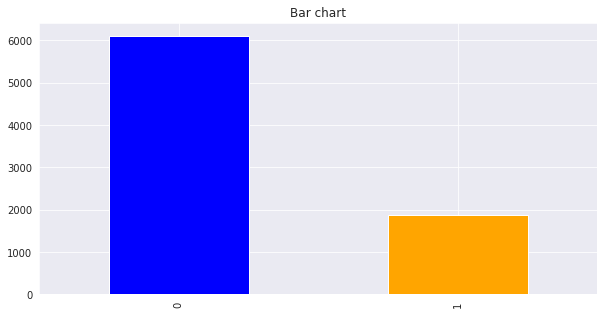

In [ ]:
ax, fig = plt.subplots()
etiquetas = texto_noticias.label.value_counts()
etiquetas.plot(kind='bar', color = ["blue", "orange"])
plt.title('Bar chart')
plt.show()

**Distribución de la longitud de los tweets en caracteres:**

In [ ]:
texto_noticias['char_len']= texto_noticias['texto_eng'].apply(lambda x: len(x)) 

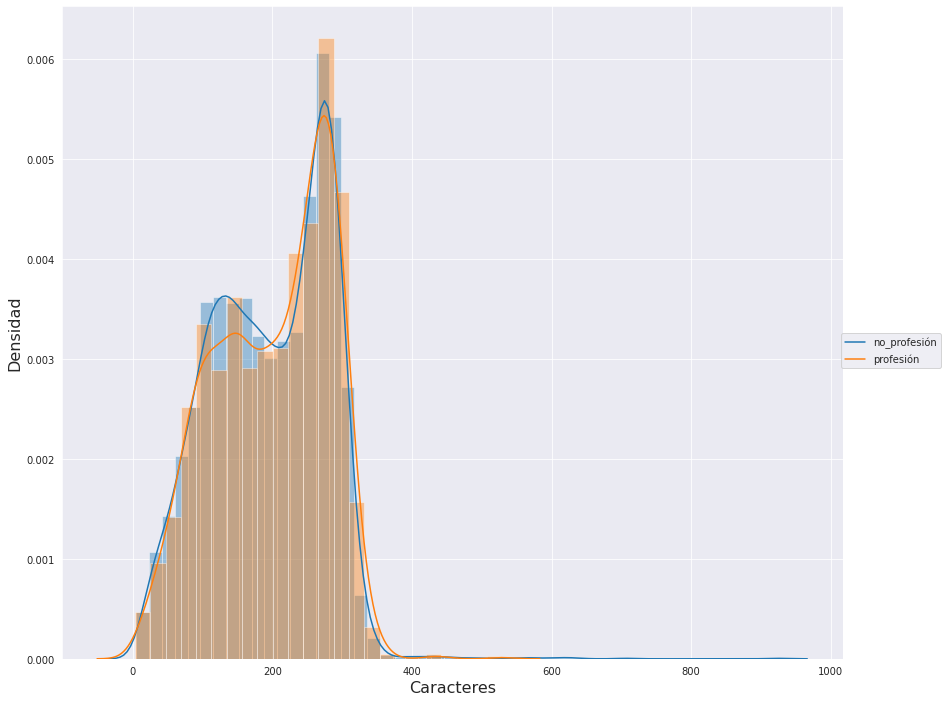

In [ ]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len_ruido)
plt1 = sns.distplot(texto_noticias[texto_noticias.label==0].char_len, hist=True, label="no_profesión")
plt2 = sns.distplot(texto_noticias[texto_noticias.label==1].char_len, hist=True, label="profesión")
fig.legend(labels=['no_profesión','profesión'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

Podemos observar como la distribución de las longitud de los tweets es muy similar.

***Wordcloud (antes de preprocesar)***

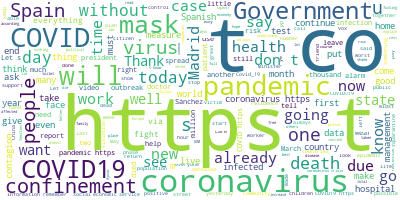

In [ ]:
from wordcloud import WordCloud
# Une las frases
long_string = ','.join(list(texto_noticias['texto_eng'].values))
# Genera un objecto WordCloud 
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
# Genera el wordcloud
wordcloud.generate(long_string)
# Visualizalo en una imagen
wordcloud.to_image()

Aparecen palabras importantes pero de la misma forma que aparecen palabras que no aportan nada.

**Normalización del texto**

In [ ]:
#Eliminar espacios 
def eliminar_espacios(text):
  return " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

# Tokenizador
from nltk.tokenize import TweetTokenizer
# Tokenizar los tweets con el tokenizador "TweetTokenizer" de NLTK
def tokenize(text):
  tweet_tokenizer = TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(text)
  return tokens_list

!pip install contractions
import contractions
# Reemplazar contracciones y slang en inglés usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    # Divide el texto
    for t in text.split():
        # Aplica la función fix en cada sección o token del texto buscando contracciones y slang
        expanded_words.append(contractions.fix(t))
    expanded_text = ' '.join(expanded_words) 
    return expanded_text

# Quitar stop words
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('english')) 
    filtrar_oración = [w for w in tokens if not w in stop_words]
    return filtrar_oración

# Eliminar signos de puntuación (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words

# Lemmatization de los tokens. Devuelve una string entera para hacer la tokenización
# con NLTK
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return (mytokens)

In [ ]:
# Eliminar espacios
texto_noticias["normaliza"] = texto_noticias["texto_eng"].progress_apply(lambda x: eliminar_espacios(x))

# To Lower
texto_noticias["normaliza"] = texto_noticias["normaliza"].progress_apply(lambda x: texto_to_lower(x))

# Quitar Contractions
texto_noticias["normaliza"] = texto_noticias["normaliza"].progress_apply(lambda x: replace_contraction(x))

# Tokenizar
texto_noticias["normaliza"] = texto_noticias["normaliza"].progress_apply(lambda x: tokenize(x))

# Quitar Stopwords
texto_noticias["normaliza"] = texto_noticias["normaliza"].progress_apply(lambda x: quitar_stopwords(x))

# Quitar puntuación
texto_noticias["normaliza"] = texto_noticias["normaliza"].progress_apply(lambda x: quitar_puntuacion(x))

# Mirar todo lo que tarda con lematización (mediante spacy)
texto_noticias["normaliza"] = texto_noticias["normaliza"].progress_apply(lambda x: lematizar(x))


texto_noticias['normaliza']

  0%|          | 0/7974 [00:00<?, ?it/s]

  0%|          | 0/7974 [00:00<?, ?it/s]

  0%|          | 0/7974 [00:00<?, ?it/s]

  0%|          | 0/7974 [00:00<?, ?it/s]

  0%|          | 0/7974 [00:00<?, ?it/s]

  0%|          | 0/7974 [00:00<?, ?it/s]

  0%|          | 0/7974 [00:00<?, ?it/s]

0       [china, release, pandemic, usa, release, ufos,...
1       [san, francisco, usa, 100, year, ago, experien...
2       [please, put, mask, 28, new, song, artist, col...
3       [new, covid, norm, reception, rule, spanish, r...
4       [confinement, leave, mental, stability, somewh...
                              ...                        
7969    [new, coronavirus, infect, multiply, almost, 2...
7970    [ayuso, awards, contract, euros, hand, make, v...
7971    [month, lock, travel, province, go, restaurant...
7972    [government, prohibit, layoff, law, coronaviru...
7973                         [psychological, trait, wear]
Name: normaliza, Length: 7974, dtype: object

In [ ]:
texto_noticias['clean_text'] = texto_noticias["normaliza"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/7974 [00:00<?, ?it/s]

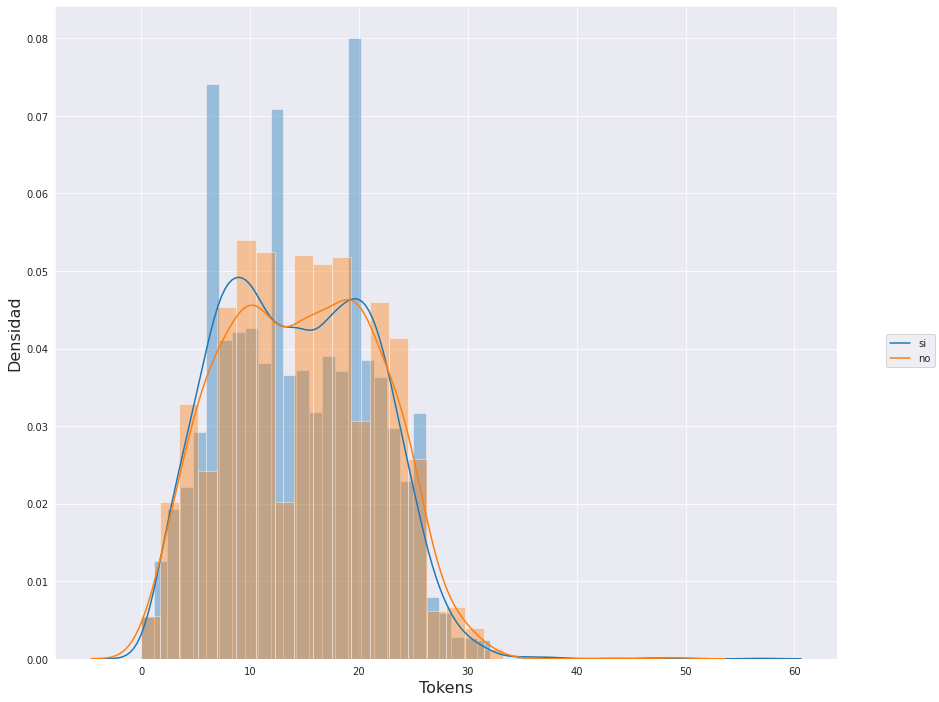

In [ ]:
texto_noticias["token_len_limpio"] = texto_noticias["normaliza"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
plt1 = sns.distplot(texto_noticias[texto_noticias.label == 0].token_len_limpio, hist=True, label="no")
plt2 = sns.distplot(texto_noticias[texto_noticias.label == 1].token_len_limpio, hist=True, label="si")
fig.legend(labels=['si','no'],loc=5)

# Definimos el título de los ejes:
plt.xlabel('Tokens', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

Vemos como la distribución de la lonitud de los tweets a sido variada a causa del pre-procesamiento. Podemos observar picos en la densidad que antes no teníamos.

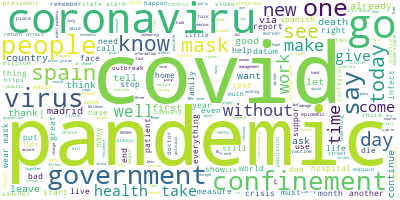

In [ ]:
from wordcloud import WordCloud
# Une las frases
long_string = ','.join(list(texto_noticias["clean_text"].values))
# Genera un objecto WordCloud 
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
# Genera el wordcloud
wordcloud.generate(long_string)
# Visualizalo en una imagen
wordcloud.to_image()

Una vez preprocesado el corpus podemos observar como han cambiado las palabras que más se usan por palabras con significados relevantes.

In [ ]:
texto_noticias

,texto_eng,label,set,char_len,normaliza,clean_text,token_len_limpio
0,['CHINA: releases a pandemic USA: releases UFO...,0,train,92,"[china, release, pandemic, usa, release, ufos,...",china release pandemic usa release ufos argent...,10
1,San Francisco (USA) 100 years ago after experi...,0,train,95,"[san, francisco, usa, 100, year, ago, experien...",san francisco usa 100 year ago experience 1918...,9
2,Please put on your mask or we will have 28 new...,0,train,93,"[please, put, mask, 28, new, song, artist, col...",please put mask 28 new song artist collaborate...,9
3,The new „covid norms and reception rules“ in t...,0,train,210,"[new, covid, norm, reception, rule, spanish, r...",new covid norm reception rule spanish retail t...,19
4,If confinement has left your mental stability ...,0,train,150,"[confinement, leave, mental, stability, somewh...",confinement leave mental stability somewhat af...,13
...,...,...,...,...,...,...,...
7969,#MostRead | The new coronavirus infected multi...,0,valid,136,"[new, coronavirus, infect, multiply, almost, 2...",new coronavirus infect multiply almost 20 time...,11
7970,"Ayuso awards a contract of 30,000 euros by han...",0,valid,137,"[ayuso, awards, contract, euros, hand, make, v...",ayuso awards contract euros hand make videos c...,11
7971,months locked up You can travel to other provi...,1,valid,281,"[month, lock, travel, province, go, restaurant...",month lock travel province go restaurant bar c...,24
7972,The government prohibits layoffs by law during...,0,valid,155,"[government, prohibit, layoff, law, coronaviru...",government prohibit layoff law coronavirus cri...,10


**Visualización**

In [ ]:
def frecuencia_tokens(lista): 
    # Creamos diccionario vacío 
    frecuencia = {} 
    for item in lista: 
        if (item in frecuencia): 
            frecuencia[item] += 1
        else: 
            frecuencia[item] = 1
    return frecuencia

from nltk.corpus.reader.tagged import word_tokenize
lista_tokens = list()
for i in texto_noticias['clean_text']:
  # Tokenizamos cada documento con word_tokenize()
  tokens_document = word_tokenize(i)
  # Añadimos esos tokens como nuevos elementos
  # Si usamos append se crearía una lista de listas, de este modo añadimos los
  lista_tokens.extend(tokens_document)



In [ ]:
from collections import Counter

In [ ]:
%%time
dict_freq = Counter(lista_tokens)
dict_freq["Road"]

CPU times: user 22.6 ms, sys: 0 ns, total: 22.6 ms
Wall time: 22.4 ms


0

In [ ]:
# Ordenamos el diccionario por la frecuencia de sus palabras
dict_freq_order = sorted(dict_freq.items(), key=lambda x: x[1], reverse=True)
token_names = list()
token_freqs = list()
for i in dict_freq_order:
  if i[1] > 350:
    token_names.append(i[0])
    token_freqs.append(i[1])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text major ticklabel objects>)

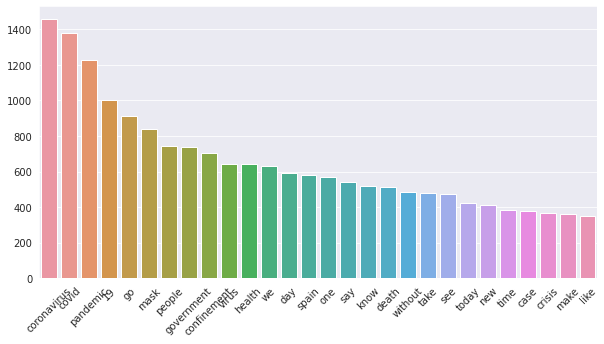

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
sns_g = sns.barplot(x=token_names, y=token_freqs)
plt.xticks(rotation=45)

**Extracción de sentimiento**

In [ ]:
from textblob import TextBlob

In [ ]:
texto_noticias["sent_subjectivity_str"] = texto_noticias["clean_text"].progress_apply(lambda x: TextBlob(x).sentiment.subjectivity)
texto_noticias["sent_polarity_str"] = texto_noticias["clean_text"].progress_apply(lambda x: TextBlob(x).sentiment.polarity)

  0%|          | 0/7974 [00:00<?, ?it/s]

  0%|          | 0/7974 [00:00<?, ?it/s]

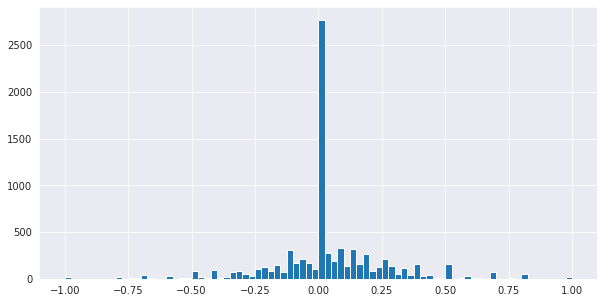

In [ ]:
texto_noticias["sent_polarity_str"].hist(bins=80)

In [ ]:
texto_noticias

,texto_eng,label,set,char_len,normaliza,clean_text,token_len_limpio,sent_subjectivity_str,sent_polarity_str
0,['CHINA: releases a pandemic USA: releases UFO...,0,train,92,"[china, release, pandemic, usa, release, ufos,...",china release pandemic usa release ufos argent...,10,0.000000,0.000000
1,San Francisco (USA) 100 years ago after experi...,0,train,95,"[san, francisco, usa, 100, year, ago, experien...",san francisco usa 100 year ago experience 1918...,9,0.000000,0.000000
2,Please put on your mask or we will have 28 new...,0,train,93,"[please, put, mask, 28, new, song, artist, col...",please put mask 28 new song artist collaborate...,9,0.454545,0.136364
3,The new „covid norms and reception rules“ in t...,0,train,210,"[new, covid, norm, reception, rule, spanish, r...",new covid norm reception rule spanish retail t...,19,0.389773,0.105682
4,If confinement has left your mental stability ...,0,train,150,"[confinement, leave, mental, stability, somewh...",confinement leave mental stability somewhat af...,13,0.433333,-0.400000
...,...,...,...,...,...,...,...,...,...
7969,#MostRead | The new coronavirus infected multi...,0,valid,136,"[new, coronavirus, infect, multiply, almost, 2...",new coronavirus infect multiply almost 20 time...,11,0.222944,0.021645
7970,"Ayuso awards a contract of 30,000 euros by han...",0,valid,137,"[ayuso, awards, contract, euros, hand, make, v...",ayuso awards contract euros hand make videos c...,11,0.000000,0.000000
7971,months locked up You can travel to other provi...,1,valid,281,"[month, lock, travel, province, go, restaurant...",month lock travel province go restaurant bar c...,24,0.600000,-0.233333
7972,The government prohibits layoffs by law during...,0,valid,155,"[government, prohibit, layoff, law, coronaviru...",government prohibit layoff law coronavirus cri...,10,0.000000,0.000000


## 4. Vectorización

In [ ]:
import gensim.downloader as api
glove_emb = api.load('glove-twitter-25') # Descargamos y cargamosel embedding de "glove-twitter-25"

In [ ]:
def get_average_vector(sentence):
  #retokenizamos con nuestra función
  tokens = tokenize(sentence)
  # Generamos lista de salida vacía
  lista = list()
  # Iteramos por cada token de la frase de entrada
  for i in tokens:
    # Si el token se encuentra en el embedding, añadir a la lista. 
    # Si no se encuentra (except), pasa al siguiente elemento.
    try:
      lista.append(glove_emb.get_vector(i))
    except:
      continue

  # Calculamos el valor medio de los vectores generados
  try:
    resultado = np.mean(lista, axis=0)  # 1vector - Dimension 25d
  except:
    # Si la lista está vacía, generar vector de ceros de tamaño el embedding
    resultado = np.zeros(25)
  return resultado

In [ ]:
texto_noticias["embeddings"] = texto_noticias["clean_text"].progress_apply(lambda x: get_average_vector(x))

  0%|          | 0/7974 [00:00<?, ?it/s]

In [ ]:
vector_data = pd.concat([texto_noticias.embeddings.apply(pd.Series),
                texto_noticias[["sent_polarity_str","sent_subjectivity_str"]]], axis=1)

In [ ]:
vector_data.shape

(7974, 27)

In [ ]:
vector_data = vector_data.fillna(0)

In [ ]:
import scipy as sp
#Extraemos las etiquetas y las asignamos a la variable y
y = texto_noticias["label"].values.astype(np.float32) 
X = sp.sparse.csc_matrix(vector_data)

## 5. Entrenamiento y evaluación de modelos


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(5980, 27)
(1994, 27)


**Rebalanceo**

In [ ]:
from collections import Counter

from sklearn.datasets import make_classification

from imblearn.over_sampling import SMOTE 

print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))


Original dataset shape Counter({0.0: 4586, 1.0: 1394})
Resampled dataset shape Counter({1.0: 4586, 0.0: 4586})


In [ ]:
np.array(np.unique(y_res,return_counts=True)).T

array([[0.000e+00, 4.586e+03],
       [1.000e+00, 4.586e+03]])

**Entrenamiento**

In [ ]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings 
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore') 
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)
          
          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)
          
          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [ ]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [ ]:
# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("SVC", SVC()),
         ("DecisionTreeClassifier", DecisionTreeClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models, evaluation_score, X_res, y_res)   

Metric: accuracy , KFold 
Logistic: 0.535101 (0.019627) 
Metric: accuracy , KFold 
SVC: 0.594092 (0.012386) 
Metric: accuracy , KFold 
DecisionTreeClassifier: 0.694290 (0.014047) 


([array([0.56535948, 0.55882353, 0.52126499, 0.56161396, 0.53544166,
         0.50817884, 0.51145038, 0.53762268, 0.52344602, 0.52780807]),
  array([0.5751634 , 0.59803922, 0.58015267, 0.58778626, 0.608506  ,
         0.59869138, 0.61286805, 0.58015267, 0.60632497, 0.59323882]),
  array([0.67973856, 0.68300654, 0.70338059, 0.70883315, 0.70010905,
         0.7044711 , 0.69138495, 0.66303162, 0.70665213, 0.70229008])],
 ['Logistic', 'SVC', 'DecisionTreeClassifier'])

Vamos a realizar un GridSearch para encontrar los mejores parametros del Decision Tree Classifier.

In [ ]:
model = DecisionTreeClassifier()
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1,10),
    'min_samples_split': range(1,10),
    "min_samples_leaf": range(1,5)
}

In [ ]:
model_grid = GridSearchCV(estimator=model,
                          param_grid=grid_param,
                          scoring='accuracy',
                          cv=10,
                          n_jobs=-1,
                          error_score=0)

In [ ]:
grid_result = model_grid.fit(X_res, y_res)

In [ ]:
print(grid_result.best_params_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4}


In [ ]:
print(grid_result.best_score_)

0.5975905374872594


In [ ]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=DecisionTreeClassifier(criterion= 'gini',
                             max_depth= 9,
                             min_samples_split= 4,
                             min_samples_leaf= 2)
model.fit(X_res,y_res)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=4)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[757 766]
 [253 218]]
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60      1523
         1.0       0.22      0.46      0.30       471

    accuracy                           0.49      1994
   macro avg       0.49      0.48      0.45      1994
weighted avg       0.62      0.49      0.53      1994



Podemos observar como claramente clasifica mejor la clase 0 que la 1. No es un gran modelo, tiene un 49% de probabilidad de predecir correctamente. Realmente el modelo no funcion bien, en mi opinión he pre-procesado correctamente los datos con los que he vectorizado y he rebalanceado los datos, no entiendo los resultados. Después de muchas pruebas mis resultados son estos, tampoco se si me tendría que salir un valor muy elevado, pero seguro que podría ser mejor.  

*   Es posible que al traducir el corpus haya tenido algun problema, ya que me resultó complicado.

*   He obviado extraer el sentimiento de los emojis, quizá hubiese aportado un poco más de valor.  

*   Se que hay el Random Forest Classifier y el Naive Bayes Classifier que pueden tener buenos resultado ens el NLP, igual podria augmentar el accuracy del F1-score.
